In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

df=pd.read_csv('../data/us_disaster_declarations.csv')

### 1.4 TEST Regularize Time Axis (Monthly) 

In [7]:
# Convert 'declaration_date' obj to dtm in new 'declaration_dtm' column
df['declaration_dtm']=pd.to_datetime(df['declaration_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Create resampled_df containing 'state', 'declaration_dtm', and 'incident_type'
subset_df=(df.assign(date=lambda d: pd.to_datetime(d['declaration_dtm'], format="%Y-%m-%d"))[['state', 'declaration_dtm', 'incident_type']])

subset_df.head()

,state,declaration_dtm,incident_type
declaration_dtm,,,
1953-05-02,GA,1953-05-02,Tornado
1953-05-15,TX,1953-05-15,Tornado
1953-05-29,LA,1953-05-29,Flood
1953-06-02,MI,1953-06-02,Tornado
1953-06-06,MT,1953-06-06,Flood


In [8]:
# Create 'month' column to filter month from 'declaration_dtm'
df['month']=pd.to_datetime(df['declaration_dtm'], format='%b').dt.month

# Create 'year' column to filter year from 'declaration_dtm'
df['year']=pd.to_datetime(df['declaration_dtm'], format='%Y').dt.year

# Create 'date' column with year-month format of each incident, with day assigned to 1
df["date"]=pd.to_datetime(df[['year', 'month']].assign(day=1))

# Create subset_df with reformatted 'date', 'incident_type', and 'state'
date_df=df[['date', 'incident_type', 'state']]

# Set index to 'date'
#subset_df=subset_df.set_index('date')

date_df.head()

,date,incident_type,state
declaration_dtm,,,
1953-05-02,1953-05-01,Tornado,GA
1953-05-15,1953-05-01,Tornado,TX
1953-05-29,1953-05-01,Flood,LA
1953-06-02,1953-06-01,Tornado,MI
1953-06-06,1953-06-01,Flood,MT


In [22]:
count_date_df=subset_df.date.value_counts().reset_index()    

count_date_df.head(30)


,date,count
0,2020-03-01,5842
1,2005-09-01,3607
2,2020-04-01,2138
3,2004-09-01,859
4,1993-03-01,824
5,2017-09-01,807
6,1996-01-01,764
7,2021-02-01,747
8,1999-09-01,634
9,2020-08-01,571


In [6]:
# Need to count incidents based on DATE
# Also may need to group based on STATE and TYPE?

# Create column 'counts' which shows the number of disasters based on 'date' (yr-mo)
#subset_df['counts']=subset_df['date'].value_counts()

# Create count_df with just the date and disaster count
#count_df=subset_df[['date', 'counts']]

#count_df.head()

counts_df=(subset_df
          .groupby(['date'])
          .size()
          .reset_index()
          )

counts_df.head()

,date,0
0,1953-05-01,3
1,1953-06-01,6
2,1953-07-01,1
3,1953-10-01,2
4,1953-12-01,1


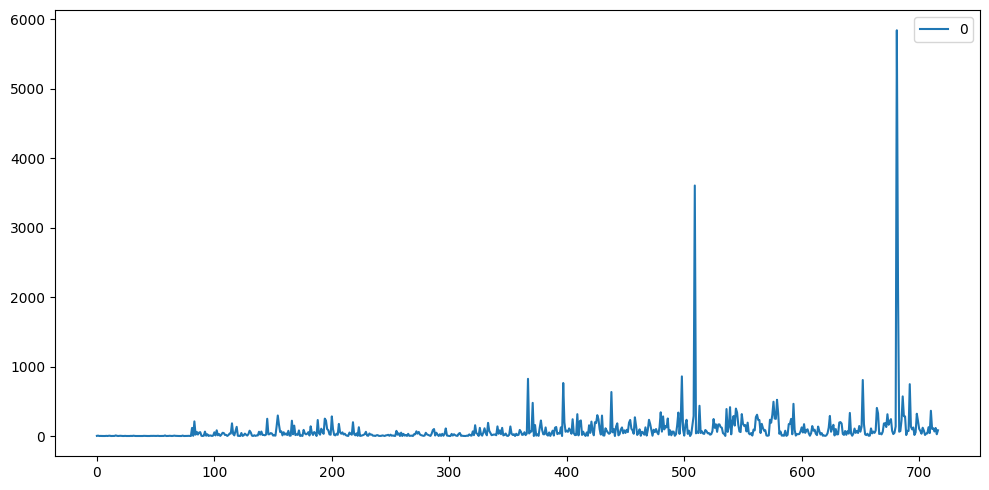

In [7]:
# Plot count_df
fig, axis=plt.subplots(figsize=(10, 5))

sns.lineplot(data=counts_df)

plt.tight_layout()

plt.show()

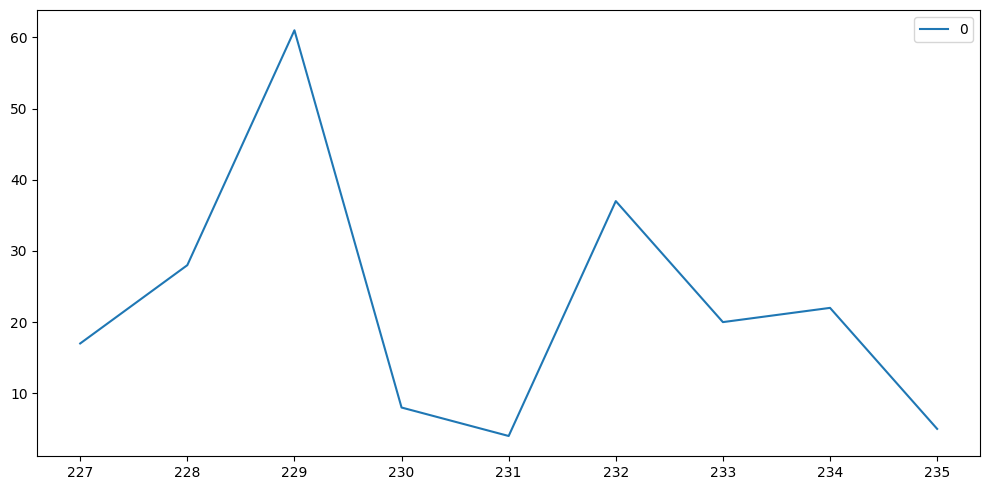

In [9]:
# Create year_df which contains 'date' and 'count' for the year 1980
year_df=counts_df[counts_df['date'].dt.strftime('%Y')=='1980']

# Plot year_df
fig, axis=plt.subplots(figsize=(10, 5))

sns.lineplot(data=year_df)

plt.tight_layout()

plt.show()

### 2. EDA

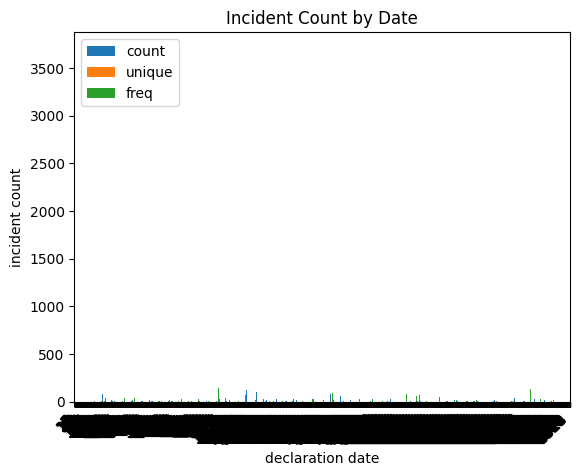

In [10]:
m=df[['declaration_date','incident_type']].groupby('declaration_date').describe()['incident_type'].reset_index()
m.plot(kind='bar')
plt.title('Incident Count by Date')
plt.xticks(rotation=45, ha='right')
plt.xlabel('declaration date')
plt.ylabel('incident count')
plt.show()